__Попробуйте улучшить работу нейронной сети рассмотренной в методическом пособии. Приложите анализ. Приложете лучшее сгенерированное изображение к уроку.__

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from IPython.display import Image, display

In [2]:
print(f"Is there a GPU available:\n{tf.config.experimental.list_physical_devices('GPU')}")

Is there a GPU available:
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
(x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()
all_cifar = np.concatenate([x_train, x_test])
all_cifar = np.reshape(all_cifar, (-1, 32, 32, 3))
all_cifar.shape

(60000, 32, 32, 3)

In [4]:
# Cifar10 
batch_size = 64
(x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()
all_cifar = np.concatenate([x_train, x_test])
all_cifar = all_cifar.astype("float32") / 127.5 - 1
dataset = tf.data.Dataset.from_tensor_slices(all_cifar)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(32)

In [5]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(32, 32, 3)),
        layers.Conv2D(64, (3, 3), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(256, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1),
    ],
    name="discriminator",
)

discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         147584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)       

In [6]:
latent_dim = 64

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        # строим размер входного вектора 8x8x128 map
        layers.Dense(4 * 4 * 256),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((4, 4, 256)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, (3, 3), padding="same", activation="tanh"),
    ],
    name="generator",
)

generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4096)              266240    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         524416    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 16, 16, 128)       0 

In [7]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]
        # берем случайный пример из скрытого пространства
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Строим по нему фейковое изображение
        generated_images = self.generator(random_latent_vectors)

        # собрали с реальным в тензор
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # задаем метки 1 и 0 соответственно
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Добавляем шум !!!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # учим discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        #Выбрали случайный пример в скрытом пространстве
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # собрали метки реальных изображений
        misleading_labels = tf.zeros((batch_size, 1))

        # Учим generator !
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        return {"d_loss": d_loss, "g_loss": g_loss}

In [8]:
path_img = "../data/img/"

class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save(f"{path_img}generated_img_{i}_{epoch}.png")

In [9]:
epochs = 200
img_nums = 5

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0004, beta_1=0.5),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=img_nums, latent_dim=latent_dim)]
)

Epoch 1/200
938/938 [==============================] - 209s 223ms/step - d_loss: 0.4820 - g_loss: 1.9791
Epoch 2/200
938/938 [==============================] - 217s 231ms/step - d_loss: 0.5769 - g_loss: 1.2706
Epoch 3/200
938/938 [==============================] - 216s 231ms/step - d_loss: 0.5248 - g_loss: 1.5206
Epoch 4/200
938/938 [==============================] - 224s 239ms/step - d_loss: 0.5204 - g_loss: 1.5186
Epoch 5/200
938/938 [==============================] - 225s 240ms/step - d_loss: 0.5206 - g_loss: 1.4717
Epoch 6/200
938/938 [==============================] - 216s 230ms/step - d_loss: 0.5927 - g_loss: 1.0951
Epoch 7/200
938/938 [==============================] - 215s 229ms/step - d_loss: 0.6160 - g_loss: 1.0221
Epoch 8/200
938/938 [==============================] - 218s 232ms/step - d_loss: 0.6151 - g_loss: 1.0222
Epoch 9/200
938/938 [==============================] - 235s 250ms/step - d_loss: 0.6119 - g_loss: 1.0425
Epoch 10/200
938/938 [==============================] -

938/938 [==============================] - 227s 242ms/step - d_loss: 0.4011 - g_loss: 1.8270
Epoch 79/200
938/938 [==============================] - 227s 242ms/step - d_loss: 0.3971 - g_loss: 1.8433
Epoch 80/200
938/938 [==============================] - 222s 237ms/step - d_loss: 0.3926 - g_loss: 1.8622
Epoch 81/200
938/938 [==============================] - 225s 240ms/step - d_loss: 0.3933 - g_loss: 1.8872
Epoch 82/200
938/938 [==============================] - 229s 244ms/step - d_loss: 0.3890 - g_loss: 1.9083
Epoch 83/200
938/938 [==============================] - 227s 242ms/step - d_loss: 0.3852 - g_loss: 1.9296
Epoch 84/200
938/938 [==============================] - 227s 242ms/step - d_loss: 0.3814 - g_loss: 1.9423
Epoch 85/200
938/938 [==============================] - 230s 245ms/step - d_loss: 0.3772 - g_loss: 1.9529
Epoch 86/200
938/938 [==============================] - 228s 243ms/step - d_loss: 0.3752 - g_loss: 1.9752
Epoch 87/200
938/938 [==============================] - 228

938/938 [==============================] - 230s 245ms/step - d_loss: 0.2139 - g_loss: 3.6353
Epoch 155/200
938/938 [==============================] - 214s 228ms/step - d_loss: 0.2141 - g_loss: 3.6441
Epoch 156/200
938/938 [==============================] - 217s 231ms/step - d_loss: 0.2147 - g_loss: 3.6577
Epoch 157/200
938/938 [==============================] - 219s 233ms/step - d_loss: 0.2153 - g_loss: 3.6931
Epoch 158/200
938/938 [==============================] - 218s 233ms/step - d_loss: 0.2190 - g_loss: 3.7386
Epoch 159/200
938/938 [==============================] - 220s 235ms/step - d_loss: 0.2205 - g_loss: 3.7233
Epoch 160/200
938/938 [==============================] - 218s 232ms/step - d_loss: 0.2203 - g_loss: 3.7536
Epoch 161/200
938/938 [==============================] - 223s 238ms/step - d_loss: 0.2270 - g_loss: 3.7517
Epoch 162/200
938/938 [==============================] - 217s 231ms/step - d_loss: 0.2244 - g_loss: 3.7522
Epoch 163/200
938/938 [============================

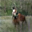

img=0, epoch=200


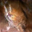

img=1, epoch=200


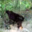

img=2, epoch=200


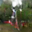

img=3, epoch=200


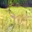

img=4, epoch=200


In [14]:
for i in range(img_nums):
    display(Image(f"{path_img}generated_img_{i}_{epochs-1}.png", width=160, height=160))
    print(f"img={i}, epoch={epochs}")

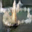

img=0, epoch=40


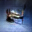

img=0, epoch=80


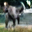

img=0, epoch=120


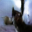

img=0, epoch=160


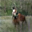

img=0, epoch=200


In [17]:
n_img = 0

for ep in range(epochs - (epochs//5)*4 - 1, epochs, epochs//5):
    display(Image(f"{path_img}generated_img_{n_img}_{ep}.png", width=160, height=160))
    print(f"img={n_img}, epoch={ep+1}")